In [155]:
# Standard Imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

from pprint import pprint

In [156]:

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [157]:
train = pd.read_csv('train_s3TEQDk.csv')
pprint(train.shape)

(245725, 11)


In [158]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [159]:
train.drop("ID", axis=1, inplace=True)

In [160]:
train["Is_Lead"].value_counts(normalize=True)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

Target calss is imbalanced

In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
Gender                 245725 non-null object
Age                    245725 non-null int64
Region_Code            245725 non-null object
Occupation             245725 non-null object
Channel_Code           245725 non-null object
Vintage                245725 non-null int64
Credit_Product         216400 non-null object
Avg_Account_Balance    245725 non-null int64
Is_Active              245725 non-null object
Is_Lead                245725 non-null int64
dtypes: int64(4), object(6)
memory usage: 18.7+ MB


### Covert Gender, Credit_Product, Is_Active to numeric

In [162]:
train['Gender'] = train['Gender'].replace({'Male':1, 'Female':0})
train['Credit_Product'] = train['Credit_Product'].fillna('None')
train['Is_Active'] = train['Is_Active'].replace({'Yes':1, 'No':0})

train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,RG268,Other,X3,43,No,1045696,0,0
1,0,30,RG277,Salaried,X1,32,No,581988,0,0
2,0,56,RG268,Self_Employed,X3,26,No,1484315,1,0
3,1,34,RG270,Salaried,X1,19,No,470454,0,0
4,0,30,RG282,Salaried,X1,33,No,886787,0,0


In [163]:
train['Credit_Product'].value_counts()

No      144357
Yes      72043
None     29325
Name: Credit_Product, dtype: int64

### OneHot encoding Occupation and  Channel_Code

In [164]:
def one_hot_encode(col, data):
    dummies = pd.get_dummies(data[col], prefix=col, prefix_sep='_', drop_first=True)
    return dummies

In [165]:
train = pd.concat([train, one_hot_encode('Occupation', train), 
                   one_hot_encode('Channel_Code', train), 
                   one_hot_encode('Credit_Product', train)], axis=1)
train.drop(['Occupation', 'Channel_Code', 'Credit_Product'], axis=1, inplace=True)

train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0


In [166]:
train.columns

Index(['Gender', 'Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance',
       'Is_Active', 'Is_Lead', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Credit_Product_None', 'Credit_Product_Yes'],
      dtype='object')

### Target Encoding the Region_Code columns

In [167]:
from category_encoders.target_encoder import TargetEncoder
enc = TargetEncoder(cols=['Region_Code'], handle_unknown='value', drop_invariant=False, return_df=True, min_samples_leaf=1)
train['Region_Code_Encoded'] = enc.fit_transform(train['Region_Code'], train[['Is_Lead']])


In [168]:
# train.drop('Region_Code', inplace=True, axis=1)
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0,0.299800
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0,0.231951
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0,0.299800
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0,0.144301
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0,0.192143


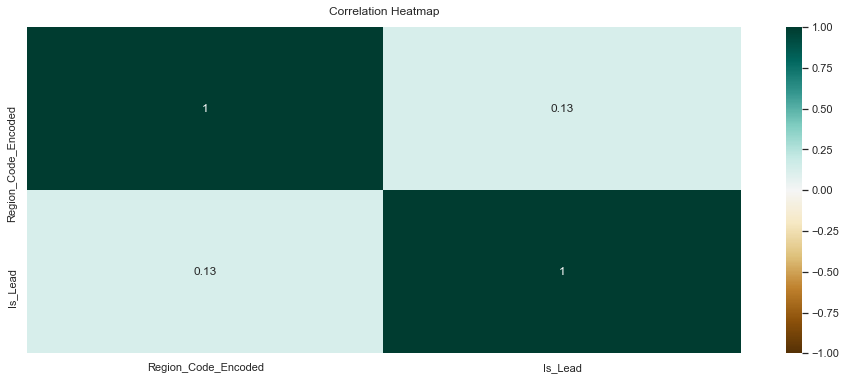

In [169]:

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train[['Region_Code_Encoded', 'Is_Lead']].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Transforminf Account Balance to LogTranform

In [170]:
train['Log_Avg_Account_Balance'] = np.log2(train['Avg_Account_Balance'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0,0.299800,20.501366
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0,0.144301,18.843694
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228


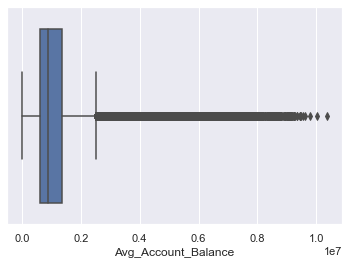

In [171]:

sns.boxplot(x='Avg_Account_Balance', hue='Is_Lead', data=train)

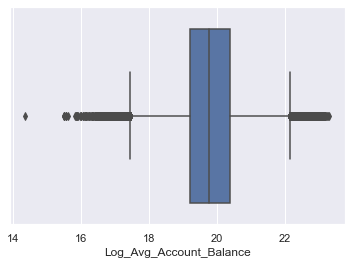

In [172]:
sns.boxplot(x='Log_Avg_Account_Balance', hue='Is_Lead', data=train)

In [173]:
print(train['Log_Avg_Account_Balance'].quantile([0.05, 0.5, 0.90, 0.95, 0.98, 1.0]))

0.05    18.429279
0.50    19.770885
0.90    20.962675
0.95    21.350316
0.98    21.813021
1.00    23.303407
Name: Log_Avg_Account_Balance, dtype: float64


In [174]:
print(train['Log_Avg_Account_Balance'].skew())

0.23517752822369867


In [178]:
Q1 = train['Log_Avg_Account_Balance'].quantile(0.05)
Q3 = train['Log_Avg_Account_Balance'].quantile(0.90)
IQR = Q3 - Q1
print(IQR)
train['Avg_Account_Balance'] = np.where(train['Avg_Account_Balance'] <Q1 , Q1 ,train['Avg_Account_Balance'])
train['Log_Avg_Account_Balance']= np.where(train['Log_Avg_Account_Balance'] >Q3 , Q3 ,train['Log_Avg_Account_Balance'])
print(train['Log_Avg_Account_Balance'].skew())

2.533395825057987
-0.30251651059199797


In [181]:
# print(train['Avg_Account_Balance'].skew())

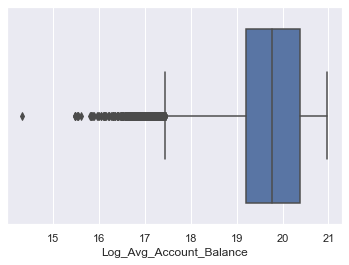

In [182]:
sns.boxplot(x='Log_Avg_Account_Balance', hue='Is_Lead', data=train)

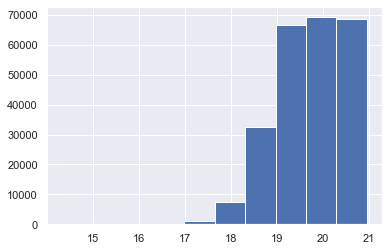

In [183]:
train['Log_Avg_Account_Balance'].hist()

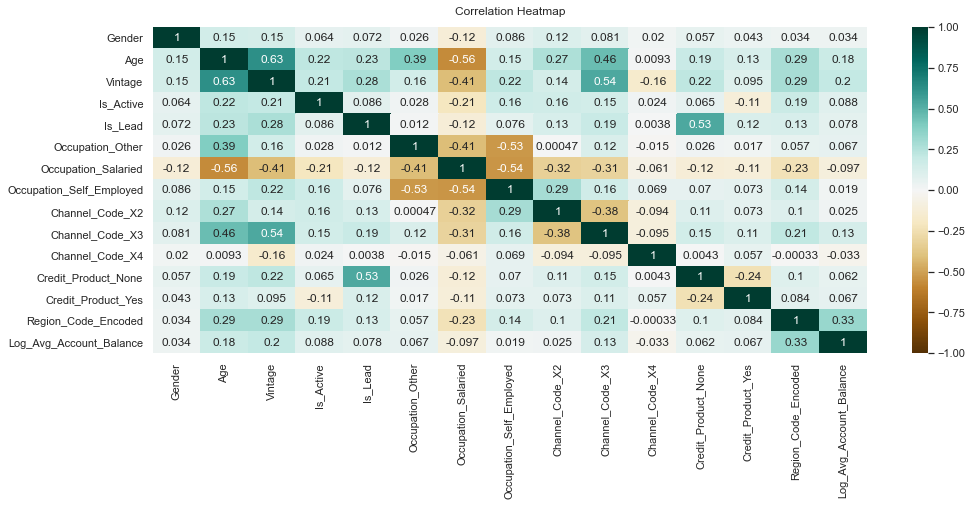

In [142]:
dataset = train.drop(['Region_Code','Avg_Account_Balance'], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [143]:
bins= [20,30,40,50,60,70, 80, 90]
labels = ['20+','30+','40+','50+','60+','70+','80+']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)


enc=LabelEncoder()
train['AgeGroup_Enc'] = enc.fit_transform(train['AgeGroup'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc
0,0,73,RG268,43,1045696.0,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032,70+,5
1,0,30,RG277,32,581988.0,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630,30+,1
2,0,56,RG268,26,1484315.0,1,0,0,0,1,0,1,0,0,0,0.299800,20.501366,50+,3
3,1,34,RG270,19,470454.0,0,0,0,1,0,0,0,0,0,0,0.144301,18.843694,30+,1
4,0,30,RG282,33,886787.0,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228,30+,1


In [144]:
bins= list(range(0, 12*13, 12))
labels = [str(i//12)+'+' for i in bins[:-1]]
train['Vintage_Group'] = pd.cut(train['Vintage'], bins=bins, labels=labels, right=False)

enc=LabelEncoder()
train['Vintage_Group_Enc'] = enc.fit_transform(train['Vintage_Group'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc,Vintage_Group,Vintage_Group_Enc
0,0,73,RG268,43,1045696.0,0,0,1,0,0,...,1,0,0,0,0.299800,19.996032,70+,5,3+,5
1,0,30,RG277,32,581988.0,0,0,0,1,0,...,0,0,0,0,0.231951,19.150630,30+,1,2+,4
2,0,56,RG268,26,1484315.0,1,0,0,0,1,...,1,0,0,0,0.299800,20.501366,50+,3,2+,4
3,1,34,RG270,19,470454.0,0,0,0,1,0,...,0,0,0,0,0.144301,18.843694,30+,1,1+,1
4,0,30,RG282,33,886787.0,0,0,0,1,0,...,0,0,0,0,0.192143,19.758228,30+,1,2+,4


In [145]:
X=train.drop(['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance', 'AgeGroup', 'Vintage_Group'], axis=1)

In [146]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 15 columns):
Gender                      245725 non-null int64
Is_Active                   245725 non-null int64
Is_Lead                     245725 non-null int64
Occupation_Other            245725 non-null uint8
Occupation_Salaried         245725 non-null uint8
Occupation_Self_Employed    245725 non-null uint8
Channel_Code_X2             245725 non-null uint8
Channel_Code_X3             245725 non-null uint8
Channel_Code_X4             245725 non-null uint8
Credit_Product_None         245725 non-null uint8
Credit_Product_Yes          245725 non-null uint8
Region_Code_Encoded         245725 non-null float64
Log_Avg_Account_Balance     245725 non-null float64
AgeGroup_Enc                245725 non-null int32
Vintage_Group_Enc           245725 non-null int32
dtypes: float64(2), int32(2), int64(3), uint8(8)
memory usage: 13.1 MB


In [147]:
y = X['Is_Lead']
X = X.drop('Is_Lead', axis=1)
X.head()

,Gender,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup_Enc,Vintage_Group_Enc
0,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032,5,5
1,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630,1,4
2,0,1,0,0,1,0,1,0,0,0,0.299800,20.501366,3,4
3,1,0,0,1,0,0,0,0,0,0,0.144301,18.843694,1,1
4,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228,1,4


In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

In [149]:
from sklearn.metrics import roc_auc_score, classification_report

In [150]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X_train_os, y_train_os = smt.fit_resample(X_train, y_train)

In [151]:
import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

In [152]:
param_dist = {'learning_rate' :0.01,
             'n_estimators':1000,
             'max_depth':12,
             'min_child_weight':1,
             'gamma':0,
             'subsample':0.8,
             'colsample_bytree':0.8,
             'objective': 'binary:logistic',
              
             'nthread':4,
             'seed':42}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train_os, y_train_os,
        eval_set=[(X_train_os, y_train_os), (X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=10,
        verbose=True)

evals_result = clf.evals_result()


[0]	validation_0-auc:0.91931	validation_1-auc:0.85007
[1]	validation_0-auc:0.92309	validation_1-auc:0.85464
[2]	validation_0-auc:0.92327	validation_1-auc:0.85504
[3]	validation_0-auc:0.92835	validation_1-auc:0.85891
[4]	validation_0-auc:0.92793	validation_1-auc:0.86484
[5]	validation_0-auc:0.93193	validation_1-auc:0.86329
[6]	validation_0-auc:0.93422	validation_1-auc:0.86467
[7]	validation_0-auc:0.93417	validation_1-auc:0.86468
[8]	validation_0-auc:0.93483	validation_1-auc:0.86448
[9]	validation_0-auc:0.93471	validation_1-auc:0.86454
[10]	validation_0-auc:0.93580	validation_1-auc:0.86455
[11]	validation_0-auc:0.93520	validation_1-auc:0.86576
[12]	validation_0-auc:0.93591	validation_1-auc:0.86556
[13]	validation_0-auc:0.93625	validation_1-auc:0.86582
[14]	validation_0-auc:0.93641	validation_1-auc:0.86552
[15]	validation_0-auc:0.93659	validation_1-auc:0.86508
[16]	validation_0-auc:0.93706	validation_1-auc:0.86547
[17]	validation_0-auc:0.93710	validation_1-auc:0.86560
[18]	validation_0-au

In [153]:
predictions = clf.predict(X_test)
from sklearn.metrics import roc_auc_score
print('AUC SCORE:',roc_auc_score(y_test, predictions))

AUC SCORE: 0.7911828842702412


### Work on Test Data

In [32]:
test_data = pd.read_csv('test_mSzZ8RL.csv')
print(test_data.shape)
test_data.head()

(105312, 10)


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [33]:
test_data['Gender'] = test_data['Gender'].replace({'Male':1, 'Female':0})
test_data['Is_Active'] = test_data['Is_Active'].replace({'Yes':1, 'No':0})

test_data['Credit_Product'] = test_data['Credit_Product'].fillna('None')

In [34]:
test_data = pd.concat([test_data, one_hot_encode('Occupation', test_data), 
                   one_hot_encode('Channel_Code', test_data), 
                   one_hot_encode('Credit_Product', test_data)], axis=1)
test_data.drop(['Occupation', 'Channel_Code', 'Credit_Product'], axis=1, inplace=True)

test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes
0,VBENBARO,1,29,RG254,25,742366,0,1,0,0,0,0,0,0,1
1,CCMEWNKY,1,43,RG268,49,925537,0,1,0,0,1,0,0,1,0
2,VK3KGA9M,1,31,RG270,14,215949,0,0,1,0,0,0,0,0,0
3,TT8RPZVC,1,29,RG272,33,868070,0,1,0,0,0,0,0,0,0
4,SHQZEYTZ,0,29,RG270,19,657087,0,1,0,0,0,0,0,0,0


In [35]:
from category_encoders.target_encoder import TargetEncoder

enc = TargetEncoder(cols=['Region_Code'], handle_unknown='value', drop_invariant=False, return_df=True, min_samples_leaf=1)
train['Region_Code_Encoded'] = enc.fit_transform(train['Region_Code'], train[['Is_Lead']])

test_data['Region_Code_Encoded'] = enc.transform(test_data['Region_Code'])


In [36]:
test_data['Log_Avg_Account_Balance'] = np.log2(test_data['Avg_Account_Balance'])

test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance
0,VBENBARO,1,29,RG254,25,742366,0,1,0,0,0,0,0,0,1,0.212854,19.501771
1,CCMEWNKY,1,43,RG268,49,925537,0,1,0,0,1,0,0,1,0,0.299800,19.819931
2,VK3KGA9M,1,31,RG270,14,215949,0,0,1,0,0,0,0,0,0,0.144301,17.720331
3,TT8RPZVC,1,29,RG272,33,868070,0,1,0,0,0,0,0,0,0,0.219916,19.727452
4,SHQZEYTZ,0,29,RG270,19,657087,0,1,0,0,0,0,0,0,0,0.144301,19.325725


In [37]:
bins= [20,30,40,50,60,70, 80, 90]
labels = ['20+','30+','40+','50+','60+','70+','80+']
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bins, labels=labels, right=False)


enc=LabelEncoder()
test_data['AgeGroup_Enc'] = enc.fit_transform(test_data['AgeGroup'])
test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc
0,VBENBARO,1,29,RG254,25,742366,0,1,0,0,0,0,0,0,1,0.212854,19.501771,20+,0
1,CCMEWNKY,1,43,RG268,49,925537,0,1,0,0,1,0,0,1,0,0.299800,19.819931,40+,2
2,VK3KGA9M,1,31,RG270,14,215949,0,0,1,0,0,0,0,0,0,0.144301,17.720331,30+,1
3,TT8RPZVC,1,29,RG272,33,868070,0,1,0,0,0,0,0,0,0,0.219916,19.727452,20+,0
4,SHQZEYTZ,0,29,RG270,19,657087,0,1,0,0,0,0,0,0,0,0.144301,19.325725,20+,0


In [38]:
bins= list(range(0, 12*13, 12))
labels = [str(i//12)+'+' for i in bins[:-1]]
test_data['Vintage_Group'] = pd.cut(test_data['Vintage'], bins=bins, labels=labels, right=False)

enc=LabelEncoder()
test_data['Vintage_Group_Enc'] = enc.fit_transform(test_data['Vintage_Group'])
test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc,Vintage_Group,Vintage_Group_Enc
0,VBENBARO,1,29,RG254,25,742366,0,1,0,0,...,0,0,0,1,0.212854,19.501771,20+,0,2+,4
1,CCMEWNKY,1,43,RG268,49,925537,0,1,0,0,...,0,0,1,0,0.299800,19.819931,40+,2,4+,6
2,VK3KGA9M,1,31,RG270,14,215949,0,0,1,0,...,0,0,0,0,0.144301,17.720331,30+,1,1+,1
3,TT8RPZVC,1,29,RG272,33,868070,0,1,0,0,...,0,0,0,0,0.219916,19.727452,20+,0,2+,4
4,SHQZEYTZ,0,29,RG270,19,657087,0,1,0,0,...,0,0,0,0,0.144301,19.325725,20+,0,1+,1


In [39]:
test_data.drop(['Age', 'Region_Code', 'Vintage', 'AgeGroup', 'Vintage_Group'], axis=1, inplace=True)

In [40]:
test_data.shape

(105312, 16)

In [41]:
test_data.columns

Index(['ID', 'Gender', 'Avg_Account_Balance', 'Is_Active', 'Occupation_Other',
       'Occupation_Salaried', 'Occupation_Self_Employed', 'Channel_Code_X2',
       'Channel_Code_X3', 'Channel_Code_X4', 'Credit_Product_None',
       'Credit_Product_Yes', 'Region_Code_Encoded', 'Log_Avg_Account_Balance',
       'AgeGroup_Enc', 'Vintage_Group_Enc'],
      dtype='object')

In [42]:
test_data_id = test_data['ID']
test_data.drop('ID', inplace=True, axis=1)

In [43]:
test_data.drop('Avg_Account_Balance', inplace=True, axis=1)

In [44]:
pred = clf.predict(test_data)

In [45]:
submission = pd.DataFrame({'ID':test_data_id, 'Is_Lead':pred})

In [46]:
submission["Is_Lead"].value_counts(normalize=True)

0    0.768972
1    0.231028
Name: Is_Lead, dtype: float64

In [47]:
submission.to_csv('xgboost_sub_3.csv', index=False)

In [333]:
submit['Is_Lead'] = pred

In [334]:
submit.to_csv('sample')

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0
5,MZZAQMPT,0
6,Y88TW36I,0
7,3UGOAQNU,0
8,VVUKMUJT,1
9,9R363ZXS,1


In [187]:
X.head()

,Gender,Credit_Product,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup_Enc,Vintage_Group_Enc
0,0,0.0,0,1,0,0,0,1,0,0.299800,19.996032,5,5
1,0,0.0,0,0,1,0,0,0,0,0.231951,19.150630,1,4
2,0,0.0,1,0,0,1,0,1,0,0.299800,20.501366,3,4
3,1,0.0,0,0,1,0,0,0,0,0.144301,18.843694,1,1
4,0,0.0,0,0,1,0,0,0,0,0.192143,19.758228,1,4


In [101]:
from sklearn.model_selection import GridSearchCV
# PARAMETERS = {"subsample":[0.5, 0.75, 1],
#                 "colsample_bytree":[0.5, 0.75, 1],
#                 "max_depth":[10,12,15],
#                 "min_child_weight":[1,5,15],
#                 "learning_rate":[0.3, 0.1, 0.03],
#                 "gamma":[0.0, 0.2, 0.4],
#                 "reg_alpha":[0.01,0.1,1],
#                 "n_estimators":[100]}

PARAMETERS = {
                "max_depth":[10,12,15],
                "min_child_weight":[1,5,15],
                }

print(PARAMETERS)

{'max_depth': [10, 12, 15], 'min_child_weight': [1, 5, 15]}


In [102]:
eval_set = [(X_train_os, y_train_os), (X_test,y_test)]

In [104]:
model = xgb.XGBClassifier(n_estimators=1000)
"""Initialise Grid Search Model to inherit from the XGBoost Model,
set the of cross validations to 3 per combination and use accuracy
to score the models."""
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="roc_auc")
#Fit the model as done previously
model_gs.fit(X_train_os, y_train_os,early_stopping_rounds=10, eval_metric="auc",eval_set=eval_set,verbose=10)
print(model_gs.best_params_)

[0]	validation_0-auc:0.90324	validation_1-auc:0.81398
[10]	validation_0-auc:0.94688	validation_1-auc:0.85846
[20]	validation_0-auc:0.95069	validation_1-auc:0.85690
[25]	validation_0-auc:0.95052	validation_1-auc:0.85331
[0]	validation_0-auc:0.90246	validation_1-auc:0.86167
[10]	validation_0-auc:0.94140	validation_1-auc:0.87073
[20]	validation_0-auc:0.95449	validation_1-auc:0.87109
[22]	validation_0-auc:0.95567	validation_1-auc:0.87089
[0]	validation_0-auc:0.89794	validation_1-auc:0.86038
[10]	validation_0-auc:0.94007	validation_1-auc:0.86918
[20]	validation_0-auc:0.95470	validation_1-auc:0.86974
[25]	validation_0-auc:0.95724	validation_1-auc:0.86959
[0]	validation_0-auc:0.90344	validation_1-auc:0.81558
[10]	validation_0-auc:0.94586	validation_1-auc:0.85839
[20]	validation_0-auc:0.94991	validation_1-auc:0.85638
[23]	validation_0-auc:0.94943	validation_1-auc:0.85407
[0]	validation_0-auc:0.90237	validation_1-auc:0.86203
[10]	validation_0-auc:0.93725	validation_1-auc:0.87059
[20]	validation

KeyboardInterrupt: 

In [369]:
predictions = model_gs.predict(X_test)
from sklearn.metrics import roc_auc_score
print('Accuracy:',roc_auc_score(y_test, predictions))

Accuracy: 0.7313336925867271
